# Explanations of machine learning models using CAM-based methods

In this tutorial you are going to examine how to use the CAM-based explanations to evaluate your ML model.

We begin by introducing the fundamental blocks used to perform an explanation on a single image:

This example corresponds to the one from the official tutorial and is used for demonstration purposes

In [ ]:
!pip install grad-cam
!pip install medmnist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 13.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.0-py3-none-any.whl size=38070 sha256=cf133f1b4253a23fda27e690053ad81bc92e5c4c496883c46f00ec9247f15917
  Stored in directory: /root/.cache/pip/wheels/5b/e5/3d/8548241d5cffe53ad1476c566a61ad9bf09cc61a9430f09726
Successfully built grad-cam
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=116934 sha256=7ed025c382bc67eeaa794991113422630c2f93e2ce46d04e7b4c99a7e50289c9
  Stored in directory: /root/.cache/pip/wheels/90/d4/f7/9404e5db0116bd4d43e5666eaa3e70ab53723e1e3ea40c9a95
Successfully built fire


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 70.9MB/s]


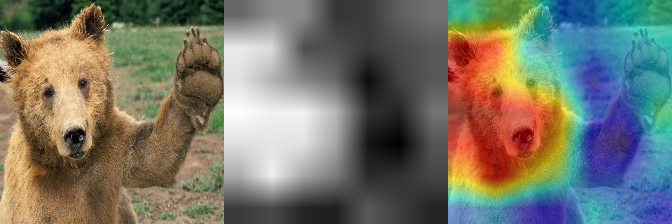

In [ ]:
import warnings
warnings.filterwarnings('ignore')
from torchvision import models
import numpy as np
import cv2
import requests
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image, \
    deprocess_image, \
    preprocess_image
from PIL import Image

model = models.resnet50(pretrained=True)
model.eval()
image_url = "https://th.bing.com/th/id/R.94b33a074b9ceeb27b1c7fba0f66db74?rik=wN27mvigyFlXGg&riu=http%3a%2f%2fimages5.fanpop.com%2fimage%2fphotos%2f31400000%2fBear-Wallpaper-bears-31446777-1600-1200.jpg&ehk=oD0JPpRVTZZ6yizZtGQtnsBGK2pAap2xv3sU3A4bIMc%3d&risl=&pid=ImgRaw&r=0"
img = np.array(Image.open(requests.get(image_url, stream=True).raw))
img = cv2.resize(img, (224, 224))
img = np.float32(img) / 255
input_tensor = preprocess_image(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# The target for the CAM is the Bear category.
# As usual for classication, the target is the logit output
# before softmax, for that category.
targets = [ClassifierOutputTarget(295)]
target_layers = [model.layer4]
with GradCAM(model=model, target_layers=target_layers) as cam:
    grayscale_cams = cam(input_tensor=input_tensor, targets=targets)
    cam_image = show_cam_on_image(img, grayscale_cams[0, :], use_rgb=True)
cam = np.uint8(255*grayscale_cams[0, :])
cam = cv2.merge([cam, cam, cam])
images = np.hstack((np.uint8(255*img), cam , cam_image))
Image.fromarray(images)

## Things to note down:

- You can change the model (any model from torchvision.models is typically fine)
- You can change the target layer (i.e. the layer which generates the predictions), but it recommended that you use the final convolutional layer
- If you do not specify the target class, then the explainer is going to select the most likely class (i.e. the class with the highest prediction confidence)

The confidence increase percent: 0.010518287308514118
The visualization of the pertubated image for the metric:


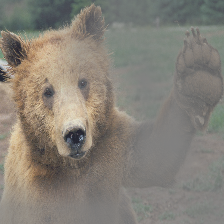

In [ ]:
# Now lets see how to evaluate this explanation:
from pytorch_grad_cam.metrics.cam_mult_image import CamMultImageConfidenceChange
from pytorch_grad_cam.utils.model_targets import ClassifierOutputSoftmaxTarget

# For the metrics we want to measure the change in the confidence, after softmax, that's why
# we use ClassifierOutputSoftmaxTarget.
targets = [ClassifierOutputSoftmaxTarget(295)]
cam_metric = CamMultImageConfidenceChange()
scores, visualizations = cam_metric(input_tensor, grayscale_cams, targets, model, return_visualization=True)
score = scores[0]
visualization = visualizations[0].cpu().numpy().transpose((1, 2, 0))
visualization = deprocess_image(visualization)
print(f"The confidence increase percent: {100*score}")
print("The visualization of the pertubated image for the metric:")
Image.fromarray(visualization)

## Benchmarking CAMs

You can use the existing benchmark method in your implementation if you wish, but it is here purely as an example of how to use different CAM attribution methods

100%|██████████| 64/64 [00:04<00:00, 13.38it/s]


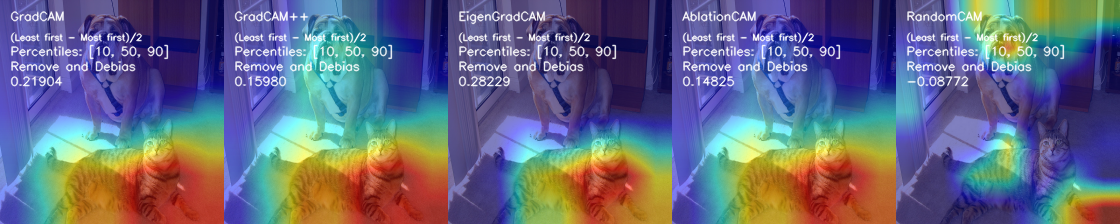

In [ ]:
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus, EigenGradCAM, AblationCAM, RandomCAM
from pytorch_grad_cam.metrics.road import ROADCombined

# Showing the metrics on top of the CAM :
def visualize_score(visualization, score, name, percentiles):
    visualization = cv2.putText(visualization, name, (10, 20),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)
    visualization = cv2.putText(visualization, "(Least first - Most first)/2", (10, 40),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255,255,255), 1, cv2.LINE_AA)
    visualization = cv2.putText(visualization, f"Percentiles: {percentiles}", (10, 55),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)
    visualization = cv2.putText(visualization, "Remove and Debias", (10, 70),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)
    visualization = cv2.putText(visualization, f"{score:.5f}", (10, 85),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)
    return visualization

def benchmark(input_tensor, target_layers, eigen_smooth=False, aug_smooth=False, category=281):
    methods = [("GradCAM", GradCAM(model=model, target_layers=target_layers)),
               ("GradCAM++", GradCAMPlusPlus(model=model, target_layers=target_layers)),
               ("EigenGradCAM", EigenGradCAM(model=model, target_layers=target_layers)),
               ("AblationCAM", AblationCAM(model=model, target_layers=target_layers)),
               ("RandomCAM", RandomCAM(model=model, target_layers=target_layers))]
# def benchmark(input_tensor, target_layers, eigen_smooth=False, aug_smooth=False, category=281):
#     methods = [("GradCAM", GradCAM(model=model, target_layers=target_layers, use_cuda=True)),
#                ("GradCAM++", GradCAMPlusPlus(model=model, target_layers=target_layers, use_cuda=True)),
#                ("EigenGradCAM", EigenGradCAM(model=model, target_layers=target_layers, use_cuda=True)),
#                ("AblationCAM", AblationCAM(model=model, target_layers=target_layers, use_cuda=True)),
#                ("RandomCAM", RandomCAM(model=model, target_layers=target_layers, use_cuda=True))]

    cam_metric = ROADCombined(percentiles=[20, 40, 60, 80])
    targets = [ClassifierOutputTarget(category)]
    metric_targets = [ClassifierOutputSoftmaxTarget(category)]

    visualizations = []
    percentiles = [10, 50, 90]
    for name, cam_method in methods:
        with cam_method:
            attributions = cam_method(input_tensor=input_tensor,
                                      targets=targets, eigen_smooth=eigen_smooth, aug_smooth=aug_smooth)
        attribution = attributions[0, :]
        scores = cam_metric(input_tensor, attributions, metric_targets, model)
        score = scores[0]
        visualization = show_cam_on_image(cat_and_dog, attribution, use_rgb=True)
        visualization = visualize_score(visualization, score, name, percentiles)
        visualizations.append(visualization)
    return Image.fromarray(np.hstack(visualizations))

cat_and_dog_image_url = "https://raw.githubusercontent.com/jacobgil/pytorch-grad-cam/master/examples/both.png"
cat_and_dog = np.array(Image.open(requests.get(cat_and_dog_image_url, stream=True).raw))
cat_and_dog = np.float32(cat_and_dog) / 255
input_tensor = preprocess_image(cat_and_dog, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
target_layers = [model.layer4]

model.cuda()
input_tensor = input_tensor.cuda()

# You can play around with the target classes, target layers and random seeds to see how the cams respond
np.random.seed(42)
benchmark(input_tensor, target_layers, eigen_smooth=False, aug_smooth=False)

# target_layers = [model.layer4[-2]]
# benchmark(input_tensor, target_layers)
# benchmark(input_tensor, target_layers, category=246)

## This section shows you how to load the MedMNIST dataset

In [ ]:
import medmnist
from medmnist import INFO, Evaluator
from torchvision import transforms, models
from torchvision.transforms import ToTensor, Lambda
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
import torch


# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data; you are free to choose the dataset yourself, but beware that not all of
# them are compatible with the standard torchvision models
data_flag = 'bloodmnist'
info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])

train_set = DataClass(split='train', transform=data_transform, target_transform=Lambda(lambda y: y[0]), download=True)
test_set = DataClass(split='test', transform=data_transform, target_transform=Lambda(lambda y: y[0]), download=True)

# You are expected to create the appropriate dataloaders to be used for training, testing and validation
# We propose a 70-15-15 split, but this is entirely up to you

### YOUR CODE BELOW ###
dataset = DataClass(split='train', transform=data_transform, target_transform=Lambda(lambda y: y[0]), download=True)

# Split dataset into 70% train, 15% validation, and 15% test
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

# Create dataloaders
batch_size = 64  # You can adjust this batch size as needed
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
valid_loader = DataLoader(val_dataset, batch_size=batch_size, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, drop_last=True)

model = models.resnet50(pretrained=False)


100%|██████████| 35461855/35461855 [00:03<00:00, 11394416.37it/s]


Using downloaded and verified file: /root/.medmnist/bloodmnist.npz
Using downloaded and verified file: /root/.medmnist/bloodmnist.npz


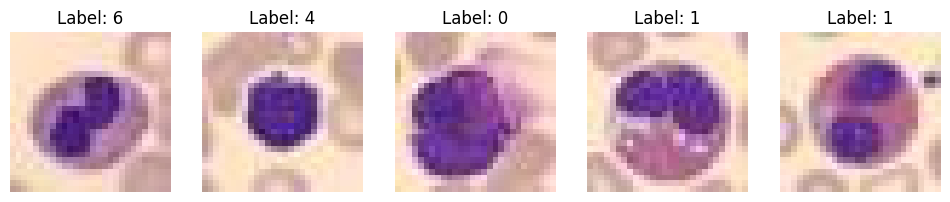

In [ ]:
import matplotlib.pyplot as plt

saved_image_train = None

def show_images( loader, num_images=5):
    global saved_image_train

    images, labels = next(iter(loader))
    plt.figure(figsize=(12, 8))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        image = images[i] * 0.5 + 0.5
        plt.imshow(image.permute(1, 2, 0))
        plt.title(f"Label: {labels[i]}")
        plt.axis('off')
        # Save the first image to the global variable
        if i == 0:
            saved_image_train = image
    plt.show()

show_images(train_loader)

In [ ]:
# ##2##
# import matplotlib.pyplot as plt

# saved_image_train = None

# def show_images( loader, num_images=5):
#     global saved_image_train

#     images, labels = next(iter(loader))
#     plt.figure(figsize=(12, 8))
#     for i in range(num_images):
#         plt.subplot(1, num_images, i + 1)
#         image = images[i] * 0.5 + 0.5
#         plt.imshow(image.permute(1, 2, 0))
#         plt.title(f"Label: {labels[i]}")
#         plt.axis('off')
#         # Save the first image to the global variable
#         if i == 0:
#             saved_image_train = image
#     plt.show()

# show_images(train_loader)

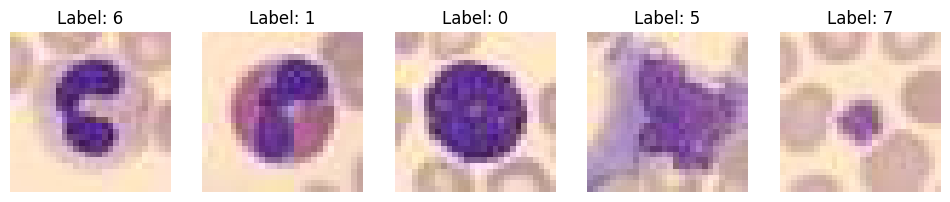

In [ ]:
import matplotlib.pyplot as plt

saved_image_test = None

def show_images( loader, num_images=5):
    global saved_image_test

    images, labels = next(iter(loader))
    plt.figure(figsize=(12, 8))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        image = images[i] * 0.5 + 0.5
        plt.imshow(image.permute(1, 2, 0))
        plt.title(f"Label: {labels[i]}")
        plt.axis('off')
        # Save the first image to the global variable
        if i == 0:
            saved_image_test = image
    plt.show()


# Display and save images from the testing set
show_images(test_loader)


In [ ]:
# ###2###
# import matplotlib.pyplot as plt

# saved_image_test = None

# def show_images( loader, num_images=5):
#     global saved_image_test

#     images, labels = next(iter(loader))
#     plt.figure(figsize=(12, 8))
#     for i in range(num_images):
#         plt.subplot(1, num_images, i + 1)
#         image = images[i] * 0.5 + 0.5
#         plt.imshow(image.permute(1, 2, 0))
#         plt.title(f"Label: {labels[i]}")
#         plt.axis('off')
#         # Save the first image to the global variable
#         if i == 0:
#             saved_image_test = image
#     plt.show()


# # Display and save images from the testing set
# show_images(test_loader)


In [ ]:
data_flag = 'bloodmnist'
info = INFO[data_flag]
print(info['description'])  # This line should print a detailed description of the dataset
print(info['label'])


The BloodMNIST is based on a dataset of individual normal cells, captured from individuals without infection, hematologic or oncologic disease and free of any pharmacologic treatment at the moment of blood collection. It contains a total of 17,092 images and is organized into 8 classes. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images with resolution 3×360×363 pixels are center-cropped into 3×200×200, and then resized into 3×28×28.
{'0': 'basophil', '1': 'eosinophil', '2': 'erythroblast', '3': 'immature granulocytes(myelocytes, metamyelocytes and promyelocytes)', '4': 'lymphocyte', '5': 'monocyte', '6': 'neutrophil', '7': 'platelet'}


### Model training

Now that you have loaded the model and the dataset, you can proceed to training it
We provide you with a sample training loop, you are allowed to modify it as you please

Your goal here is to add the explanations to either the validation or the testing loop
It is entirely up to you how to achieve this; the main goal of the exercise is to observe how
the explanations change over the course of training.

Hint: you may want to run the explainer on the untrained model to get a baseline 'random' prediction

In [ ]:
!pip install pytorch-gradcam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 24.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pytorch-gradcam: filename=pytorch_gradcam-0.2.1-py3-none-any.whl size=5248 sha256=77d5fb5f66f4ff83398d56c0f1fa0f8eeb7447bbcf5747d10136077cb041c0c8
  Stored in directory: /root/.cache/pip/wheels/6f/f1/8f/96c81d13f617841f23cae192a77fea3e9e988d058ba9414f2c
Successfully built pytorch-gradcam


In [ ]:
###############

# Showing the metrics on top of the CAM :
def visualize_score(visualization, score, name, percentiles):
    visualization = cv2.putText(visualization, name, (10, 20),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)
    visualization = cv2.putText(visualization, "(Least first - Most first)/2", (10, 40),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255,255,255), 1, cv2.LINE_AA)
    visualization = cv2.putText(visualization, f"Percentiles: {percentiles}", (10, 55),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)
    visualization = cv2.putText(visualization, "Remove and Debias", (10, 70),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)

    return visualization

def benchmark(flag,input_tensor, target_layers, eigen_smooth=False, aug_smooth=False, category=281):
    methods = [
               ("GradCAM++", GradCAMPlusPlus(model=model, target_layers=target_layers)),
               ("EigenGradCAM", EigenGradCAM(model=model, target_layers=target_layers)),
               ("RandomCAM", RandomCAM(model=model, target_layers=target_layers))]


    cam_metric = ROADCombined(percentiles=[20, 40, 60, 80])
    targets = [ClassifierOutputTarget(category)]
    metric_targets = [ClassifierOutputSoftmaxTarget(category)]

    visualizations = []
    percentiles = [10, 50, 90]
    for name, cam_method in methods:
        with cam_method:
            attributions = cam_method(input_tensor=input_tensor,
                                      targets=targets, eigen_smooth=eigen_smooth, aug_smooth=aug_smooth)
        attribution = attributions[0, :]
        scores = cam_metric(input_tensor, attributions, metric_targets, model)
        score = scores[0]
        if(flag):
          visualization = show_cam_on_image(saved_image_numpy_train, attribution, use_rgb=True)###############
        else:
          visualization = show_cam_on_image(saved_image_numpy_test, attribution, use_rgb=True)###############

        visualization = visualize_score(visualization, score, name, percentiles)
        visualizations.append(visualization)
    return Image.fromarray(np.hstack(visualizations))



###############

In [ ]:
import cv2
import numpy as np

saved_image_numpy = saved_image_train.squeeze().cpu().numpy()
saved_image_numpy = saved_image_numpy.transpose(1, 2, 0)
saved_image_numpy = cv2.resize(saved_image_numpy, (224, 224), interpolation=cv2.INTER_CUBIC)
saved_image_numpy_train = saved_image_numpy / 255.0

print(saved_image_numpy.shape)

(224, 224, 3)


In [ ]:
saved_image_numpy = saved_image_test.squeeze().cpu().numpy()
saved_image_numpy = saved_image_numpy.transpose(1, 2, 0)
saved_image_numpy = cv2.resize(saved_image_numpy, (224, 224), interpolation=cv2.INTER_CUBIC)
saved_image_numpy_test = saved_image_numpy / 255.0

print(saved_image_numpy.shape)

(224, 224, 3)


In [ ]:
from PIL import Image
import torchvision.transforms as transforms
# Resize the saved image to 224x224
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt

def train(device, model, train_loader, valid_loader, epochs, learning_rate):
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    best_valid_loss = float('inf')
    best_model_state_dict = None

    for epoch in range(epochs):
        model.train()
        losses = []
        valid_losses = []
        accuracies = []

        for i, (data, target) in enumerate(tqdm(train_loader, desc='Training-loop')):
            optimizer.zero_grad()
            data, target = data.to(device), target.to(device)
            output = model(data)
            output = output.squeeze()
            loss = criterion(output, target)
            preds = torch.argmax(output.detach().cpu(), axis=1)
            labels = target.detach().cpu()
            acc = np.mean(preds.numpy() == labels.numpy())
            losses.append(loss.item())
            accuracies.append(acc)
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            for idx, (data, target) in enumerate(tqdm(valid_loader, desc='Validation-loop')):
                data, target = data.to(device), target.to(device)
                pred = model(data)
                pred = pred.squeeze()
                loss = criterion(pred, target)
                valid_losses.append(loss.item())

        if np.mean(valid_losses) < best_valid_loss:
            best_valid_loss = np.mean(valid_losses)
            best_model_state_dict = model.state_dict()



        print(
            f"Train Epoch: {epoch + 1} "
            f"Loss: {np.mean(losses):.6f} "
            f"Validation loss: {np.mean(valid_losses):.6f} "
            f"Acc: {np.mean(accuracies) * 100:.6f} "
        )

        # We suggest you modify this code to run the continuous explanations
        print(f"Grad-cam testing")

        target_layers = [model.layer4]
        saved_image_tensor = torch.from_numpy(saved_image_numpy_train)
        if saved_image_tensor.max() > 1:
            saved_image_tensor = saved_image_tensor / 255.0
        saved_image_tensor = saved_image_tensor.permute(2, 0, 1)
        input_tensor = transform(saved_image_tensor).unsqueeze(0).cuda()
        np.random.seed(42)
        x = benchmark(1,input_tensor, target_layers, eigen_smooth=False, aug_smooth=False)
        plt.imshow(x)
        plt.axis('off')
        plt.show()



    # Save the best model
    if best_model_state_dict is not None:
        torch.save(best_model_state_dict, 'best_model.pth')

    return model



Validation-loop: 100%|██████████| 28/28 [00:01<00:00, 18.45it/s]


Train Epoch: 1 Loss: 1.058562 Validation loss: 0.784209 Acc: 66.814904 
Grad-cam testing


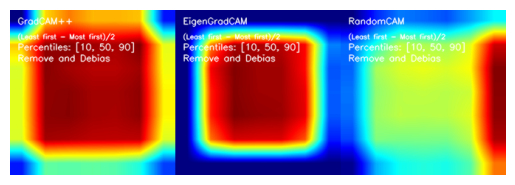

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
trained_model = train(device, model, train_loader, valid_loader, epochs=1, learning_rate=0.001)

Validation-loop: 100%|██████████| 28/28 [00:01<00:00, 14.07it/s]


Train Epoch: 1 Loss: 0.752986 Validation loss: 0.622599 Acc: 75.372596 
Grad-cam testing


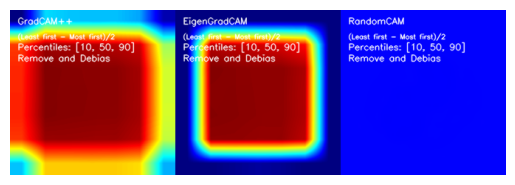

In [ ]:
###2###
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
trained_model = train(device, model, train_loader, valid_loader, epochs=1, learning_rate=0.001)

Validation-loop: 100%|██████████| 28/28 [00:00<00:00, 44.13it/s]


Train Epoch: 1 Loss: 0.600114 Validation loss: 0.571198 Acc: 79.218750 
Grad-cam testing


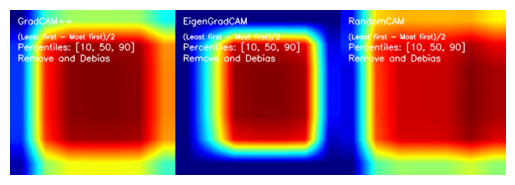

In [ ]:
###3###
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
trained_model = train(device, model, train_loader, valid_loader, epochs=1, learning_rate=0.001)

In [ ]:
import numpy as np
import torch
from tqdm import tqdm

def test(device, model, test_loader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    pred_list = []

    with torch.no_grad():
        for images, targets in tqdm(test_loader, desc='Test-loop'):
            images, targets = images.to(device), targets.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
            pred_list.extend(predicted.cpu().numpy())

    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')

#     # You should modify this section to reflect your CAM evaluation
#     # print(f"Grad-cam testing")
#     # target_layers = None
#     # with GradCAM(model=model, target_layers=target_layers, use_cuda=True) as cam:
#     #     pass
    print(f"Grad-cam testing")
    target_layers = [model.layer4]
    saved_image_tensor = torch.from_numpy(saved_image_numpy_test)
    if saved_image_tensor.max() > 1:
        saved_image_tensor = saved_image_tensor / 255.0
    saved_image_tensor = saved_image_tensor.permute(2, 0, 1)
    input_tensor = transform(saved_image_tensor).unsqueeze(0).cuda()
    np.random.seed(42)
    x = benchmark(0,input_tensor, target_layers, eigen_smooth=False, aug_smooth=False)
    plt.imshow(x)
    plt.axis('off')
    plt.show()

    return np.array(pred_list)

Test-loop: 100%|██████████| 28/28 [00:00<00:00, 35.23it/s]


Test Accuracy: 77.68%
Grad-cam testing


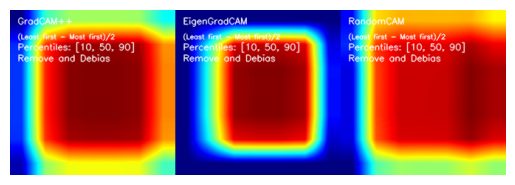

In [ ]:
test = test(device, model, test_loader)

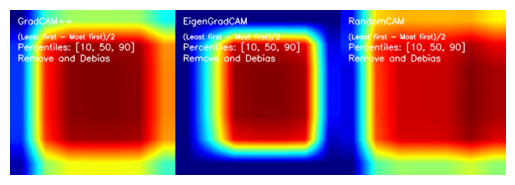

In [ ]:
target_layers = [model.layer4]
saved_image_tensor = torch.from_numpy(saved_image_numpy_train)
if saved_image_tensor.max() > 1:
    saved_image_tensor = saved_image_tensor / 255.0
saved_image_tensor = saved_image_tensor.permute(2, 0, 1)
input_tensor = transform(saved_image_tensor).unsqueeze(0).cuda()
np.random.seed(42)
heat_map = benchmark(1,input_tensor, target_layers, eigen_smooth=False, aug_smooth=False)
plt.imshow(heat_map)
plt.axis('off')
plt.show()

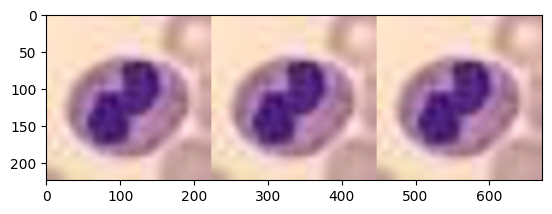

In [ ]:
target_layers = [model.layer4]
saved_image_tensor = torch.from_numpy(saved_image_numpy_train)
if saved_image_tensor.max() > 1:
    saved_image_tensor = saved_image_tensor / 255.0
saved_image_tensor = saved_image_tensor.permute(2, 0, 1)
input_tensor = transform(saved_image_tensor).unsqueeze(0).cuda()
np.random.seed(42)
heat_map = benchmark(1,input_tensor, target_layers, eigen_smooth=False, aug_smooth=False)
# plt.imshow(heat_map)
# plt.axis('off')
# plt.show()

image_data = np.transpose(saved_image_train, (1, 2, 0))
img = image_data.numpy()
pil_img =  Image.fromarray((img * 255).astype(np.uint8))
pil_img_resized = pil_img.resize((224, 224))

original_image = pil_img_resized

new_width = original_image.width * 3
new_height = 224

# Create a new image by stacking the resized original images horizontally
stacked_image = Image.new('RGB', (new_width, new_height))
for i in range(3):
    stacked_image.paste(pil_img_resized, (i * pil_img_resized.width, 0))

# plt.imshow(stacked_image)

# Ensure both images have the same size
if stacked_image.size != heat_map.size:
    raise ValueError("Images must be of the same size")

# Create a new image by blending the two images together
merged_image = Image.blend(stacked_image, heat_map, alpha=0.5)
merged_image = Image.blend(stacked_image, merged_image, alpha=0.7)

plt.imshow(merged_image)

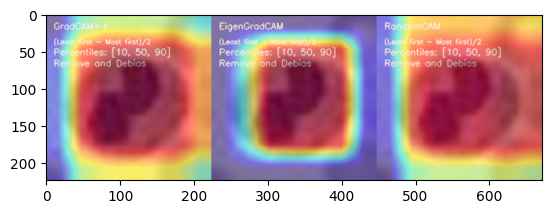

In [ ]:
# Ensure both images have the same size
if stacked_image.size != heat_map.size:
    raise ValueError("Images must be of the same size")

# Create a new image by blending the two images together
merged_image = Image.blend(stacked_image, heat_map, alpha=0.5)

plt.imshow(merged_image)

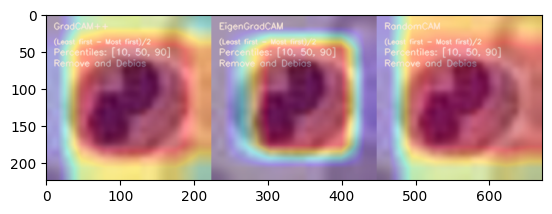

In [ ]:
# Ensure both images have the same size
if stacked_image.size != heat_map.size:
    raise ValueError("Images must be of the same size")

# Create a new image by blending the two images together
merged_image = Image.blend(stacked_image, heat_map, alpha=0.5)
merged_image = Image.blend(stacked_image, merged_image, alpha=0.7)

plt.imshow(merged_image)